In [1]:
%pylab inline
import uproot
import pandas as pd
import awkward as ak
from yahist import Hist1D, Hist2D
import mplhep as hep
plt.style.use(hep.styles.CMS)
from scipy.stats import gaussian_kde

Populating the interactive namespace from numpy and matplotlib


In [2]:
f = uproot.open("../output/data_driven_photon_dfs/photon_df_lepton_id_no_gamma_mva_id.root") # no photon ID selections applied, but lepton selections applie
t = f["t"]

In [3]:
dfs = t.arrays(library="pd")

Let us understand the final states here

Text(0.5, 1.0, 'Category distribution in the $\\gamma$ + Jets sample')

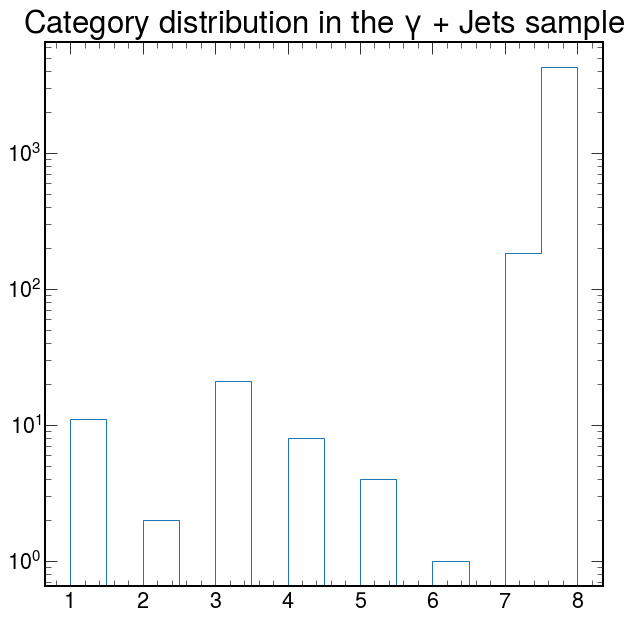

In [4]:
Hist1D(dfs.loc[dfs["process_id"] > 0, "Category"]).plot()
plt.yscale("log")
plt.title("Category distribution in the $\gamma$ + Jets sample")

So it's mostly Categories 7 and 8, which makes sense as faking two leptons is usually more rare than faking one 

# $\gamma$ + Jets background estimation

### Get the distribution of fake photon ID MVA from the GJets MC events

Assert that the photon that fails ID cuts is usually the fake one

In [5]:
# Get the number of events where the first photon is fake and the second photon is real, and the first photon has higher ID

print("Number of outliers = ", sum(dfs.loc[(dfs["g1_isFake"] == 1) & (dfs["g2_isFake"] == 0), "g1_idmva"] >= dfs.loc[(dfs["g1_isFake"] == 1) & (dfs["g2_isFake"] == 0), "g2_idmva"]))
print("number of events = ", len(dfs.loc[(dfs["g1_isFake"] == 1) & (dfs["g2_isFake"] == 0), "g1_idmva"]))

Number of outliers =  63
number of events =  1434


In [6]:
# Get the number of events where the second photon is fake and the first photon is real, and the second photon has higher ID

print("Number of outliers = ", sum(dfs.loc[(dfs["g1_isFake"] == 0) & (dfs["g2_isFake"] == 1), "g2_idmva"] >= dfs.loc[(dfs["g1_isFake"] == 0) & (dfs["g2_isFake"] == 1), "g1_idmva"]))
print("Number of events = ", len(dfs.loc[(dfs["g1_isFake"] == 0) & (dfs["g2_isFake"] == 1), "g2_idmva"]))

Number of outliers =  71
Number of events =  1952


So approx 4\% outliers to our hypothesis - consistent with what Sam saw

Tangential conclusion - photon ID does not depend on lepton flavour (as expected)

Add real and fake photon ID MVA categories

In [7]:
Hist1D(dfs.loc[dfs["process_id"] > 0, "g1_isFake"] + dfs.loc[dfs["process_id"] > 0, "g2_isFake"], weights=dfs.loc[dfs["process_id"] > 0, "weight"])

[15421.31 ± 1055.09    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   62159.07 ± 2035.44
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
 214.47 ± 68.77]

In [8]:
Hist1D(dfs.loc[dfs["process_id"] > 0, "g1_isFake"] + dfs.loc[dfs["process_id"] > 0, "g2_isFake"], weights=dfs.loc[dfs["process_id"] > 0, "weight"])

[15421.31 ± 1055.09    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   62159.07 ± 2035.44
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
 214.47 ± 68.77]

In [9]:
dfs["n_fake_photons"] = ((dfs["g1_isFake"] + dfs["g2_isFake"]))
dfs["fake_photon_idmva"] = np.ones(len(dfs)) * -999
dfs["real_photon_idmva"] = np.ones(len(dfs)) * -999

dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "real_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "g2_idmva"]
dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "fake_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "g1_idmva"]

dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "real_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "g1_idmva"]
dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "fake_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "g2_idmva"]

#### Correlation plots

In [10]:
def compute_correlation(v1, v2):
    return ((v1*v2).mean() - (v1.mean()) * (v2.mean())) / (v1.std() * v2.std())

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0.00556626949488751

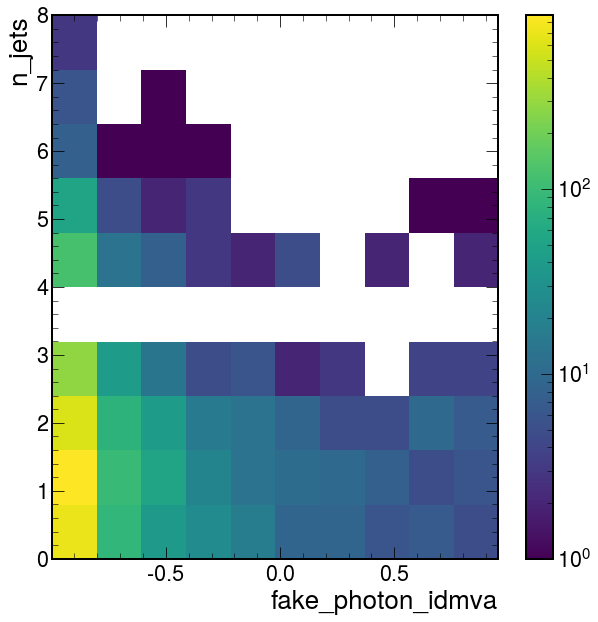

In [11]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "n_jets"]])
x.plot(logz=True)
plt.savefig("fake_id_v_n_jets.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "n_jets"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


-0.004121461879956882

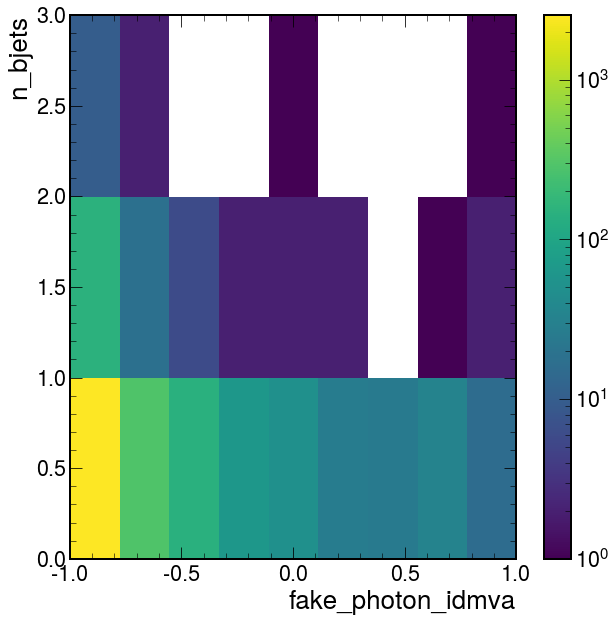

In [12]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "n_bjets"]], bins=(linspace(-1,1,10), arange(0,4,1)))
x.plot(logz=True)
plt.savefig("fake_id_v_n_bjets.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "n_bjets"])


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


-0.01885380846263155

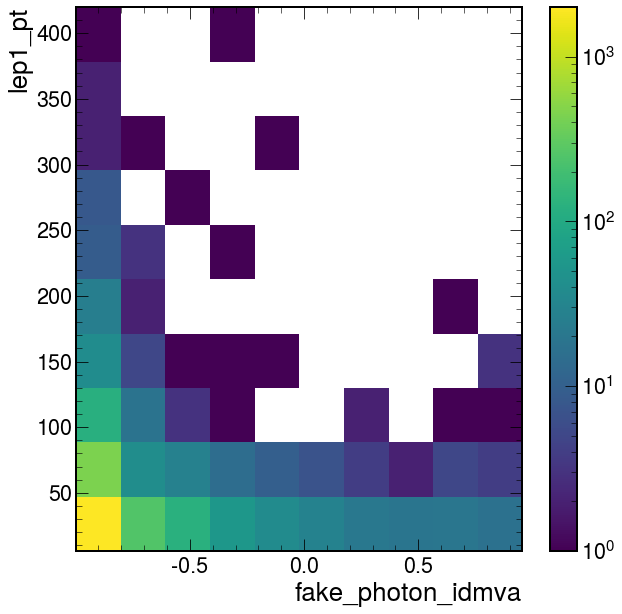

In [13]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "lep1_pt"]])
x.plot(logz=True)
plt.savefig("fake_id_v_lep_1_pt.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "lep1_pt"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0.003663435733167634

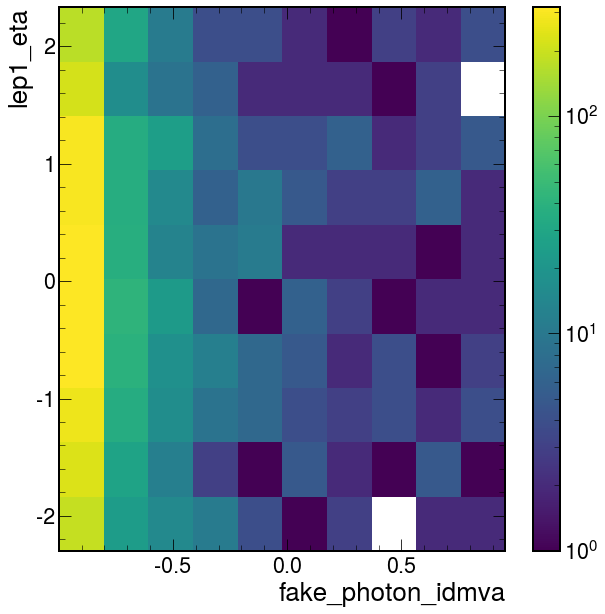

In [14]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "lep1_eta"]])
x.plot(logz=True)
plt.savefig("fake_id_v_lep_1_eta.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "lep1_eta"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


-0.030147297397907568

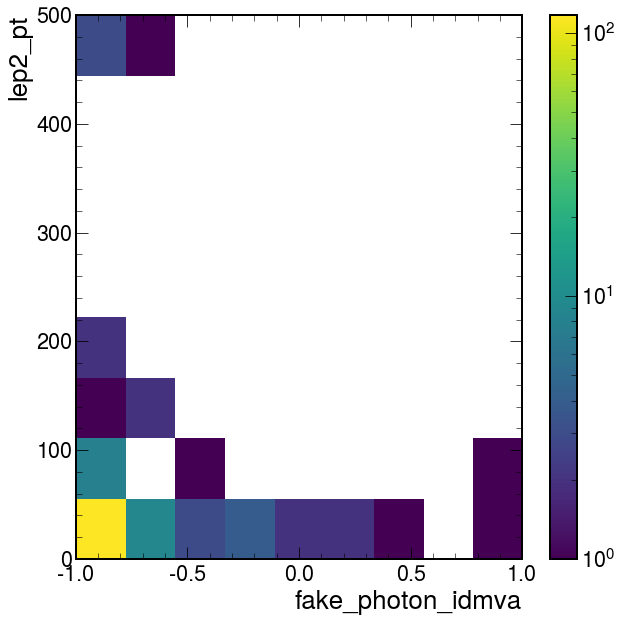

In [15]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), ["fake_photon_idmva", "lep2_pt"]], bins=(linspace(-1,1,10), linspace(0,500,10)))
x.plot(logz=True)
plt.savefig("fake_id_vs_lep_2_pt.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "lep2_pt"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0.03421247461216695

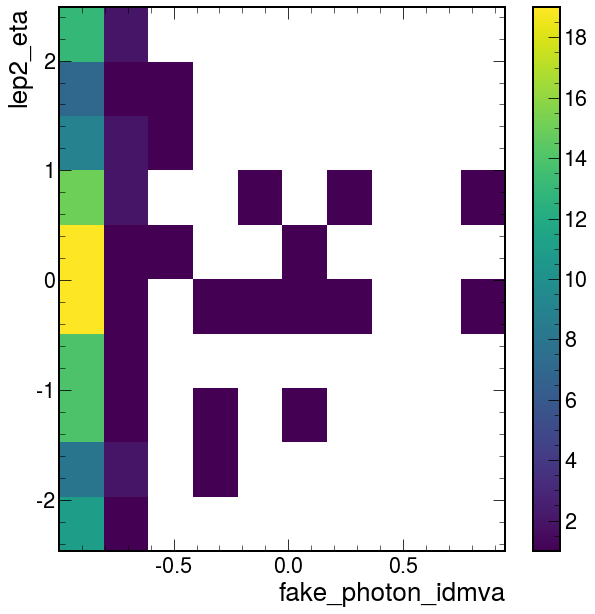

In [16]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), ["fake_photon_idmva", "lep2_eta"]])
x.plot()
plt.savefig("fake_id_vs_lep_2_eta.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "lep2_eta"])

Given that we've established that the fake photon ID MVA is uncorrelated with the other variables, we can replace these in data with the sampled values without any issues

### Generating fake IDs

In [17]:
dfs["max_gamma_idmva"] = np.ones(len(dfs)) * -999
dfs["min_gamma_idmva"] = np.ones(len(dfs)) * -999

dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "max_gamma_idmva"] = dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "g1_idmva"]
dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "min_gamma_idmva"] = dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "g2_idmva"]

dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "max_gamma_idmva"] = dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "g2_idmva"]
dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "min_gamma_idmva"] = dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "g1_idmva"]

In [18]:
data_df = dfs.loc[dfs["process_id"] == 0].copy()
data_df["max_gamma_idmva"] = np.ones(len(data_df)) * -999
data_df["min_gamma_idmva"] = np.ones(len(data_df)) * -999

data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "max_gamma_idmva"] = data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "g1_idmva"]
data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "min_gamma_idmva"] = data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "g2_idmva"]

data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "max_gamma_idmva"] = data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "g2_idmva"]
data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "min_gamma_idmva"] = data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "g1_idmva"]

Replace min_gamma_idmva with the sampled value for those events where min_gamma_idmva <= -0.7 and max_gamma_idmva > -0.7

### Using the pre lepton selection samples to create the fake ID distribution

In [19]:
f = uproot.open("../output/data_driven_photon_dfs/photon_df_no_lepton_id_no_gamma_mva_id.root")
t = f["t"]

In [20]:
parentDF = t.arrays(library="pd")

Ultimately, we need to compare the yields after $\gamma$ selection

In [21]:
data_parentDF = parentDF.loc[parentDF["process_id"] == 0].copy()
data_parentDF["max_gamma_idmva"] = np.ones(len(data_parentDF)) * -999
data_parentDF["min_gamma_idmva"] = np.ones(len(data_parentDF)) * -999

data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "max_gamma_idmva"] = data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "g1_idmva"]
data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "min_gamma_idmva"] = data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "g2_idmva"]

data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "max_gamma_idmva"] = data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "g2_idmva"]
data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "min_gamma_idmva"] = data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "g1_idmva"]

In [22]:
parentDF

,MET_dil_dphi,n_taus,n_electrons,jet2_id,lep12_dphi,jet2_bTag,gg_eta,tt_hel_vis,jet2_eta_bdt,MET_pt,...,g1_ptmgg,pt_tautau_SVFit,g2_pixVeto,lep12_dR,MET_phi,lep1_charge,gg_tt_hel_vis,eta_tautau_SVFit,eta_bdt_tautau_SVFit,phi_tautau_SVFit
0,-0.719360,0.0,0.0,-999.0,0.0,-999.000000,2.580260,1.0,-999.000000,38.080658,...,0.461614,0.000000,0.0,0.0,0.719360,-999.0,4.371139e-08,0.0,0.0,0.000000
1,-1.005127,0.0,0.0,-999.0,0.0,-999.000000,3.696579,1.0,-999.000000,16.149218,...,0.463273,0.000000,0.0,0.0,1.005127,-999.0,4.371139e-08,0.0,0.0,0.000000
2,-0.112823,0.0,0.0,-999.0,0.0,-999.000000,2.995089,1.0,-999.000000,30.793530,...,0.437107,0.000000,0.0,0.0,0.112823,-999.0,4.371139e-08,0.0,0.0,0.000000
3,-1.584473,0.0,0.0,-999.0,0.0,-999.000000,0.579111,1.0,-999.000000,27.345707,...,0.496964,0.000000,0.0,0.0,1.584473,-999.0,4.371139e-08,0.0,0.0,0.000000
4,2.554199,0.0,0.0,7.0,0.0,0.035828,-1.354119,1.0,-2.072754,39.672356,...,0.544012,0.000000,0.0,0.0,-2.554199,-999.0,4.371139e-08,0.0,-0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19843293,-3.002687,0.0,0.0,6.0,0.0,0.006939,1.859221,1.0,1.132812,36.882896,...,0.445988,1333.333374,0.0,0.0,-0.112442,-999.0,4.371139e-08,inf,inf,-3.115129
19843294,-999.000000,1.0,0.0,-999.0,-999.0,-999.000000,-0.253674,-999.0,-999.000000,40.611900,...,0.832809,-999.000000,0.0,-999.0,1.617920,1.0,-9.990000e+02,-999.0,-999.0,-999.000000
19843295,0.017684,0.0,0.0,-999.0,0.0,-999.000000,-2.070966,1.0,-999.000000,26.442757,...,0.697627,1333.333374,0.0,0.0,-3.132812,-999.0,4.371139e-08,inf,-inf,-3.115129
19843296,1.138272,0.0,0.0,6.0,0.0,0.005455,-2.368446,1.0,-1.220947,30.029984,...,1.198723,1333.333374,0.0,0.0,2.029785,-999.0,4.371139e-08,inf,-inf,-3.115129


In [23]:
parentDF["n_fake_photons"] = ((parentDF["g1_isFake"] + parentDF["g2_isFake"]))
parentDF["fake_photon_idmva"] = np.ones(len(parentDF)) * -999
parentDF["real_photon_idmva"] = np.ones(len(parentDF)) * -999

parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "real_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "g2_idmva"]
parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "fake_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "g1_idmva"]

parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "real_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "g1_idmva"]
parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "fake_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "g2_idmva"]

In [24]:
model = gaussian_kde(parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "fake_photon_idmva"], bw_method="silverman", weights= abs(parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "weight"]))

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


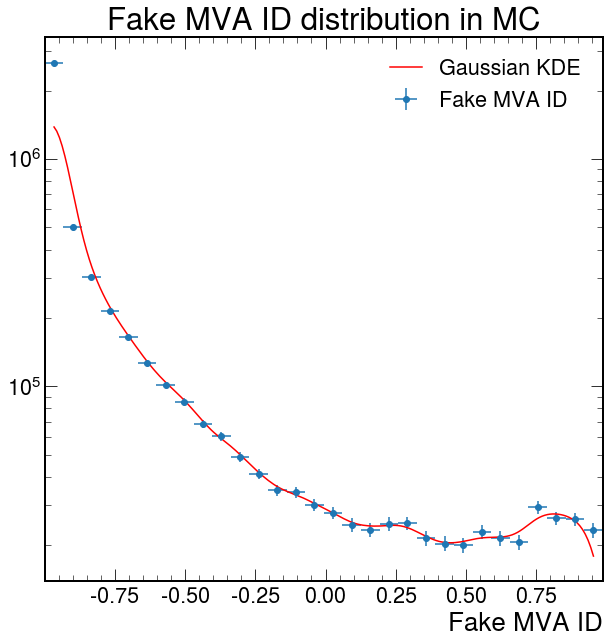

In [25]:
idHist = Hist1D(parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "fake_photon_idmva"], weights=parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "weight"], bins=30)
idHist.plot(show_errors=True, label="Fake MVA ID")
sample_points = linspace(min(idHist.bin_centers), max(idHist.bin_centers), 200)
pdf = model.pdf(sample_points) * idHist.integral * idHist.bin_widths[0]
plt.plot(sample_points, pdf, "r", label="Gaussian KDE")
plt.yscale("log")
plt.xlabel("Fake MVA ID")
plt.legend()
plt.title("Fake MVA ID distribution in MC")
plt.savefig("fake_mva_id_mc_distribution_inclusive.pdf")

## Sample from the new distribution!

First things first, check if real $\gamma$ MVA ID and fake $\gamma$ MVA ID are correlated

In [26]:
tempHist = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), ["g1_idmva", "g2_idmva"]], weights=dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), "weight"])

-0.10512336728502826

In [28]:
dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), ["g1_idmva", "g2_idmva"]]
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), "g1_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), "g2_idmva"])

-0.0916175

### Reproduce AN

In [29]:
from tqdm.notebook import tqdm

Elaborate columnar method!

In [32]:
counter = 0
data_df["min_gamma_idmva_sim"] = np.ones(len(data_df)) * -999
background_selection = (data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7)
bar = tqdm(total=sum(background_selection))
iterationBar = tqdm()
while not (all(data_df.loc[background_selection, "min_gamma_idmva_sim"] < data_df.loc[background_selection, "max_gamma_idmva"]) and all(data_df.loc[background_selection, "min_gamma_idmva_sim"] > -0.7)):
    sample_selection = (background_selection) & ((data_df["min_gamma_idmva_sim"] <= -0.7) | (data_df["max_gamma_idmva"] <= data_df["min_gamma_idmva_sim"]))
    length = sum(sample_selection)
    counter += 1
    iterationBar.update(1)
    
    data_df.loc[sample_selection, "min_gamma_idmva_sim"] = model.resample(length)[0]
    newLength = sum((background_selection) & ((data_df["min_gamma_idmva_sim"] <= -0.7) | (data_df["max_gamma_idmva"] <= data_df["min_gamma_idmva_sim"])))
    delta = length - newLength
    bar.update(delta)
    

  0%|          | 0/130728 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [36]:
background_selection = (data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7)

In [37]:
data_df.loc[((background_selection) & (data_df["min_gamma_idmva_sim"] < -0.7) | (data_df["min_gamma_idmva_sim"] > data_df["max_gamma_idmva"]))]

,dPhi_ggtautau_SVFit,n_taus,n_electrons,jet2_id,lep12_dphi,jet2_bTag,gg_eta,tt_hel_vis,jet2_eta_bdt,MET_pt,...,eta_tautau_SVFit,eta_bdt_tautau_SVFit,phi_tautau_SVFit,MET_dil_dphi,n_fake_photons,fake_photon_idmva,real_photon_idmva,max_gamma_idmva,min_gamma_idmva,min_gamma_idmva_sim
7079,-999.0,1.0,0.0,-999.0,-999.0,-999.0,1.320504,-999.0,-999.0,31.663918,...,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-0.699707,-0.997559,-0.961859


In [40]:
# selection after simulation!
selection = (data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva_sim"] > -0.7)

In [41]:
from multiprocessing import Pool
from tqdm import tqdm


def integrate_model(x):
    result = np.zeros_like(x)
    for i in tqdm(range(len(x))):
        result[i] = model.integrate_box_1d(-0.7,x[i]) / model.integrate_box_1d(-1, -0.7)
    return result

#Choose number of cores and split input array.
cores = 16
torun = np.array_split(data_df.loc[selection, "max_gamma_idmva"].values, cores)

pool = Pool(processes=cores)
results = pool.map(integrate_model, torun)
result = np.concatenate(results)

100%|██████████| 8171/8171 [04:10<00:00, 32.61it/s]


In [42]:
data_df.loc[selection, "weight"] = result

In [43]:
dfs.columns

Index(['dPhi_ggtautau_SVFit', 'n_taus', 'n_electrons', 'jet2_id', 'lep12_dphi',
       'jet2_bTag', 'gg_eta', 'tt_hel_vis', 'jet2_eta_bdt', 'MET_pt',
       ...
       'gg_tt_hel_vis', 'eta_tautau_SVFit', 'eta_bdt_tautau_SVFit',
       'phi_tautau_SVFit', 'MET_dil_dphi', 'n_fake_photons',
       'fake_photon_idmva', 'real_photon_idmva', 'max_gamma_idmva',
       'min_gamma_idmva'],
      dtype='object', length=103)

In [61]:
# Assign the simulated ID MVAs to the appropriate photon branches

In [62]:
data_df.loc[selection & (data_df["g1_idmva"] <= -0.7), "g1_idmva"] = data_df.loc[selection & (data_df["g1_idmva"] <= -0.7), "min_gamma_idmva_sim"]
data_df.loc[selection & (data_df["g2_idmva"] <= -0.7), "g2_idmva"] = data_df.loc[selection & (data_df["g2_idmva"] <= -0.7), "min_gamma_idmva_sim"]

In [63]:
data_df.loc[selection & (data_df["g1_idmva"] <= -0.7), "g1_idmva"]

Series([], Name: g1_idmva, dtype: float32)

In [130]:
with uproot.recreate("GJets_background.root") as f:
    f["t"] = data_df.loc[selection]

In [158]:
# Resorting to the saved DF to save time
with uproot.open("GJets_background.root") as f:
    df = f["t"].arrays(library="pd")

In [159]:
all(df["Category"] > 0) # Leptonic selections incorporated!

True

In [160]:
# Normalization wrt the standard ggMass distributions!
from yahist import Hist1D
from yahist.utils import plot_stack

In [161]:
process_ids = {}
process_ids["Data"] = 0

process_ids["HH_ggTauTau"] = -1
#process_ids["HH_ggZZ"] = -2
#process_ids["HH_ggZZ_4l"] = -5
#process_ids["HH_ggZZ_2l2q"] = -6
process_ids["HH_ggWW_dileptonic"] = -3
process_ids["HH_ggWW_semileptonic"] = -4

process_ids["DiPhoton"] = 3
process_ids["GJets"] = 8
process_ids["TTGG"] = 7
process_ids["TTGamma"] = 6
process_ids["TTbar"] = 5
process_ids["VH"] = 9
process_ids["WGamma"] = 4
process_ids["ZGamma"] = 2
process_ids["ttH"] = 10
process_ids["ggH"] = 11
process_ids["VBFH"] = 12

In [162]:
is_resonant = {}

is_resonant["Data"] = False
is_resonant["DiPhoton"] = False
is_resonant["GJets"] = False
is_resonant["HH_ggTauTau"] = True
is_resonant["HH_ggZZ"] = True
is_resonant["HH_ggWW_dileptonic"] = True
is_resonant["HH_ggWW_semileptonic"] = True
is_resonant["HH_ggZZ_4l"] = True
is_resonant["HH_ggZZ_2l2q"] = True
is_resonant["TTGG"] = False
is_resonant["TTGamma"] = False
is_resonant["TTbar"] = False
is_resonant["VH"] = True
is_resonant["WGamma"] = False
is_resonant["ZGamma"] = False
is_resonant["ttH"] = True
is_resonant["ggH"] = True
is_resonant["VBFH"] = True

In [163]:
colors = {}
colors["Data"] = "k"
colors["DiPhoton"] = "C0"
colors["GJets"] = "C1"
colors["HH_ggTauTau"] = "k"
colors["HH_ggZZ"] = "b"
colors["HH_ggWW"] = "g"
colors["TTbar"] = "C3"
colors["VH"] = "C4"
colors["WGamma"] = "C5"
colors["ZGamma"] = "C6"
colors["ttH"] = "C7"
colors["ggH"] = "C8"
colors["VBFH"] = "C2"

In [164]:
t = uproot.open("../output/run2_all_with_isoTrack_isolation_no_HHggZZ.root")["t"]
master_df = t.arrays(library="pd")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


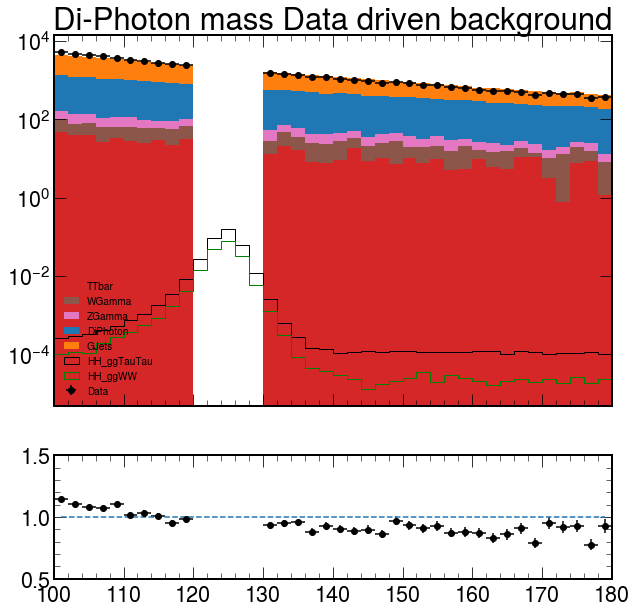

In [256]:
mgg_binning = "40,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["mgg"]
        weight = df["weight"] 
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "mgg"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Di-Photon mass Data driven background")
plt.savefig("mgg_data_driven.pdf")

In [166]:
# Overall normalization factor!

In [167]:
total_except_GJets

[1317.20 ± 19.78   1222.43 ± 18.66   1170.55 ± 18.31   1093.33 ± 17.20
 1066.71 ± 17.53   997.59 ± 17.25   919.65 ± 16.41   878.97 ± 16.09
 835.57 ± 14.62   814.64 ± 15.10    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   568.37 ± 12.03
 558.08 ± 12.64   523.30 ± 11.54   495.36 ± 11.60   450.73 ± 10.62
 459.20 ± 11.72   441.59 ± 11.14   397.84 ± 9.66   397.58 ± 10.81
 377.38 ± 10.39   367.18 ± 9.42   340.58 ± 9.43   336.74 ± 9.73
 314.57 ± 8.59   309.33 ± 9.20   286.48 ± 8.47   265.47 ± 7.38
 256.73 ± 8.60   246.98 ± 7.99   229.59 ± 7.94   216.51 ± 7.65
 218.34 ± 7.34   222.38 ± 7.79   206.11 ± 7.52   184.86 ± 6.84]

In [168]:
total_background

[4559.43 ± 38.07   4259.34 ± 36.65   4011.99 ± 35.53   3815.63 ± 34.47
 3451.33 ± 32.99   3291.00 ± 32.37   2990.25 ± 30.82   2808.07 ± 29.91
 2659.71 ± 28.54   2478.50 ± 27.87    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   1612.45 ± 22.17
 1515.47 ± 21.84   1421.79 ± 20.77   1381.02 ± 20.76   1270.34 ± 19.69
 1213.53 ± 19.72   1148.36 ± 18.96   1058.53 ± 17.75   1006.52 ± 17.97
 915.48 ± 16.98   895.58 ± 16.31   831.97 ± 15.93   793.64 ± 15.75
 741.91 ± 14.80   722.16 ± 14.95   649.38 ± 13.91   626.09 ± 13.27
 607.35 ± 13.90   561.92 ± 13.03   537.30 ± 12.93   484.09 ± 12.18
 484.27 ± 12.00   487.70 ± 12.31   451.06 ± 11.82   409.98 ± 11.12]

In [169]:
assert(total_except_GJets + mgg_hists["GJets"] == total_background) # No errors => Assertion worked!
GJets_from_subtraction = mgg_hists["Data"] - total_except_GJets
scale_factor = GJets_from_subtraction.integral / mgg_hists["GJets"].integral

In [170]:
scale_factor

0.9784163112731884

In [171]:
master_df["max_gamma_idmva"] = np.zeros(len(master_df))
master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "max_gamma_idmva"] =master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "g1_idmva"]
master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "max_gamma_idmva"] =master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "g2_idmva"]

In [172]:
master_df["min_gamma_idmva"] = np.zeros(len(master_df))
master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "min_gamma_idmva"] =master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "g2_idmva"]
master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "min_gamma_idmva"] =master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "g1_idmva"]

In [173]:
df ["max_gamma_idmva"] = np.zeros(len(df))
df.loc[(df["g1_idmva"] > df["g2_idmva"]), "max_gamma_idmva"] =df.loc[(df["g1_idmva"] > df["g2_idmva"]), "g1_idmva"]
df.loc[(df["g2_idmva"] > df["g1_idmva"]), "max_gamma_idmva"] =df.loc[(df["g2_idmva"] > df["g1_idmva"]), "g2_idmva"]

In [174]:
df["min_gamma_idmva"] = np.zeros(len(df))
df.loc[(df["g1_idmva"] > df["g2_idmva"]), "min_gamma_idmva"] =df.loc[(df["g1_idmva"] > df["g2_idmva"]), "g2_idmva"]
df.loc[(df["g2_idmva"] > df["g1_idmva"]), "min_gamma_idmva"] =df.loc[(df["g2_idmva"] > df["g1_idmva"]), "g1_idmva"]

Text(0.5, 1.0, 'Max $\\gamma$ MVA ID')

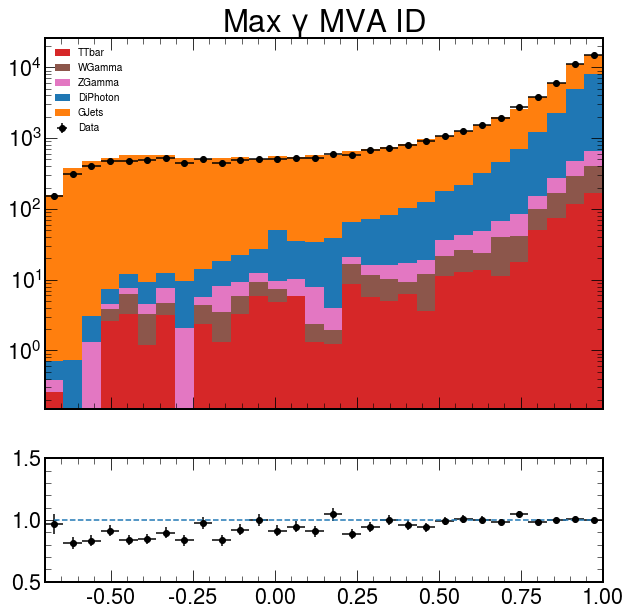

In [175]:
mgg_binning = "30,-0.7,1" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["max_gamma_idmva"]
        weight = df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "max_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
# mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Max $\gamma$ MVA ID")

In [176]:
# Bin-by-bin normalization of the minimum photon ID MVA

Text(0.5, 1.0, 'Minimum $\\gamma$ MVA ID')

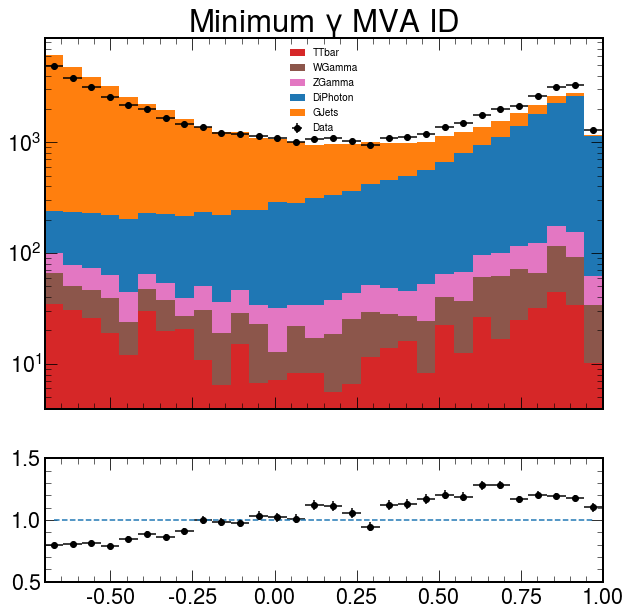

In [177]:
mgg_binning = "30,-0.7,1" # ROOT convention

min_gamma_idmva_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["min_gamma_idmva"]
        weight = df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "min_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        min_gamma_idmva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        min_gamma_idmva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
min_gamma_idmva_hists["TTbar"] += min_gamma_idmva_hists["TTGamma"] + min_gamma_idmva_hists["TTGG"]

hist_stack = [hist for process, hist in min_gamma_idmva_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
min_gamma_idmva_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# min_gamma_idmva_hists["HH_ggWW"] = min_gamma_idmva_hists["HH_ggWW_dileptonic"] + min_gamma_idmva_hists["HH_ggWW_semileptonic"]
# min_gamma_idmva_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# min_gamma_idmva_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = min_gamma_idmva_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Minimum $\gamma$ MVA ID")

In [178]:
scale_hist = (min_gamma_idmva_hists["Data"] - total_except_GJets) / min_gamma_idmva_hists["GJets"]

In [179]:
scale_hist_bin_left = scale_hist.bin_centers - (scale_hist.bin_widths) / 2
scale_hist_bin_right = scale_hist.bin_centers + (scale_hist.bin_widths) / 2

In [180]:
len(scale_hist_bin_left), len(scale_hist.counts)

(30, 30)

In [181]:
for i in range(len(scale_hist_bin_left)):
    df.loc[(df["min_gamma_idmva"] >= scale_hist_bin_left[i]) & (df["min_gamma_idmva"] < scale_hist_bin_right[i]), "weight"] *= scale_hist.counts[i]

Text(0.5, 1.0, 'Minimum $\\gamma$ MVA ID')

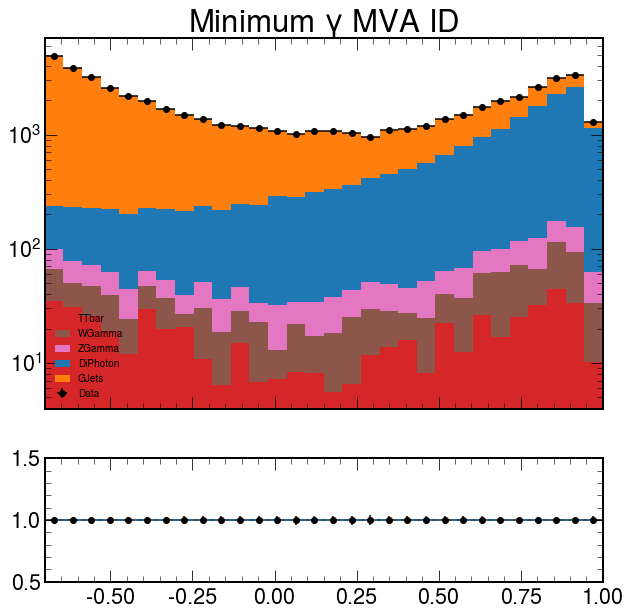

In [182]:
mgg_binning = "30,-0.7,1" # ROOT convention

min_gamma_idmva_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["min_gamma_idmva"]
        weight = df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "min_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        min_gamma_idmva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        min_gamma_idmva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
min_gamma_idmva_hists["TTbar"] += min_gamma_idmva_hists["TTGamma"] + min_gamma_idmva_hists["TTGG"]

hist_stack = [hist for process, hist in min_gamma_idmva_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
min_gamma_idmva_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# min_gamma_idmva_hists["HH_ggWW"] = min_gamma_idmva_hists["HH_ggWW_dileptonic"] + min_gamma_idmva_hists["HH_ggWW_semileptonic"]
# min_gamma_idmva_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# min_gamma_idmva_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = min_gamma_idmva_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Minimum $\gamma$ MVA ID")

Text(0.5, 1.0, 'Max $\\gamma$ MVA ID')

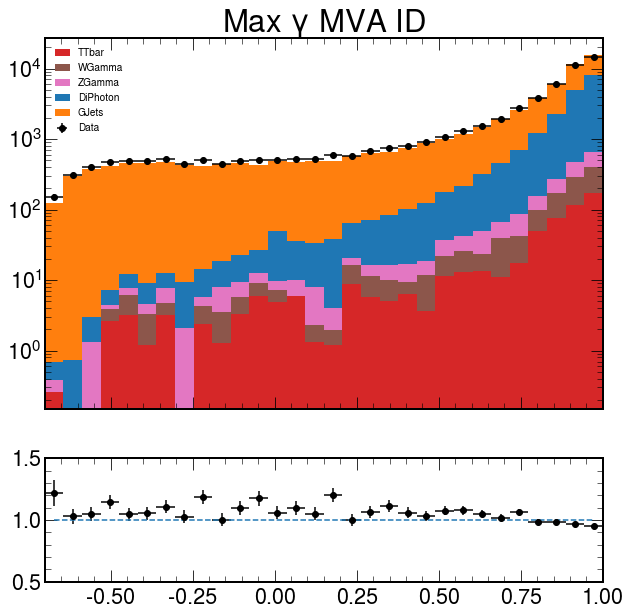

In [183]:
mgg_binning = "30,-0.7,1" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["max_gamma_idmva"]
        weight = df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "max_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
# mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Max $\gamma$ MVA ID")

Text(0.5, 1.0, 'Di-Photon mass Non-resonant backgrounds')

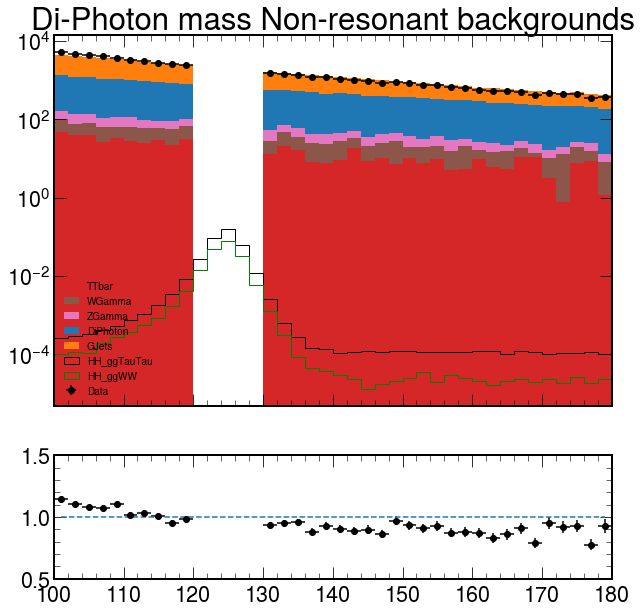

In [184]:
mgg_binning = "40,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["mgg"]
        weight = df["weight"] 
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "mgg"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Di-Photon mass Non-resonant backgrounds")

In [191]:
## Yield computation

Data = 1691.0 $\pm$ 41.1
DiPhoton = 405.9 $\pm$ 7.3
GJets = 1132.8 $\pm$ 21.0
TTbar = 34.6 $\pm$ 7.9
WGamma = 25.2 $\pm$ 4.6
ZGamma = 17.2 $\pm$ 2.5
total background = 1616.7 $\pm$ 24.2


In [244]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["mgg"]
        weight = df["weight"] 
    else:
        toFill = master_df.loc[(master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

background = Hist1D(np.zeros(1), bins=mgg_binning)
print("inclusive")
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.3f} $\pm$ {:0.3f}".format(ratio.integral, ratio.errors[0]))

inclusive
Data = 55351.0 $\pm$ 235.3
DiPhoton = 16966.0 $\pm$ 55.6
GJets = 36363.1 $\pm$ 119.4
TTbar = 540.2 $\pm$ 31.9
WGamma = 683.8 $\pm$ 29.2
ZGamma = 797.9 $\pm$ 16.9
total background = 55352.0 $\pm$ 139.7
Ratio = 1.000 $\pm$ 0.005


In [245]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df.loc[df["Category"] == 8, "mgg"]
        weight = df.loc[(df["Category"] == 8), "weight"] 
    else:
        toFill = master_df.loc[(master_df["Category"] == 8) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["Category"] == 8) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

background = Hist1D(np.zeros(1), bins=mgg_binning)
print("1tau0lep")
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

1tau0lep
Data = 52876.0 $\pm$ 229.9
DiPhoton = 16356.1 $\pm$ 54.8
GJets = 34760.6 $\pm$ 116.7
TTbar = 390.0 $\pm$ 27.8
WGamma = 633.7 $\pm$ 28.2
ZGamma = 438.7 $\pm$ 12.6
total background = 52580.1 $\pm$ 135.5
Ratio = 1.0 $\pm$ 0.01


In [246]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df.loc[df["Category"] == 7, "mgg"]
        weight = df.loc[(df["Category"] == 7), "weight"] 
    else:
        toFill = master_df.loc[(master_df["Category"] == 7) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["Category"] == 7) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("1 tau0lep_iso")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

1 tau0lep_iso
Data = 1691.0 $\pm$ 41.1
DiPhoton = 405.9 $\pm$ 7.3
GJets = 1132.8 $\pm$ 21.0
TTbar = 34.6 $\pm$ 7.9
WGamma = 25.2 $\pm$ 4.6
ZGamma = 17.2 $\pm$ 2.5
total background = 1616.7 $\pm$ 24.2


In [251]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df.loc[(df["Category"] == 1) | (df["Category"] == 2), "mgg"]
        weight = df.loc[(df["Category"] == 1) | (df["Category"] == 2), "weight"] 
    else:
        toFill = master_df.loc[((master_df["Category"] == 1) | (master_df["Category"] == 2)) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[((master_df["Category"] == 1) | (master_df["Category"] == 2)) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("1tau1lep")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

1tau1lep
Data = 213.0 $\pm$ 14.6
DiPhoton = 31.8 $\pm$ 2.0
GJets = 124.5 $\pm$ 7.4
TTbar = 56.0 $\pm$ 9.0
WGamma = 20.0 $\pm$ 5.1
ZGamma = 77.6 $\pm$ 5.4
total background = 310.8 $\pm$ 14.0
Ratio = 0.7 $\pm$ 0.06


In [254]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df.loc[(df["Category"] == 3), "mgg"]
        weight = df.loc[(df["Category"] == 3), "weight"] 
    else:
        toFill = master_df.loc[(master_df["Category"] == 3) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["Category"] == 3) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("2tau0lep")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

2tau0lep
Data = 247.0 $\pm$ 15.7
DiPhoton = 112.3 $\pm$ 4.3
GJets = 166.0 $\pm$ 8.4
TTbar = 11.8 $\pm$ 2.9
WGamma = -0.3 $\pm$ 2.4
ZGamma = 15.9 $\pm$ 2.4
total background = 306.6 $\pm$ 10.5
Ratio = 0.8 $\pm$ 0.06


In [249]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df.loc[(df["Category"] == 4) | (df["Category"] == 5) | (df["Category"] == 6), "mgg"]
        weight = df.loc[((df["Category"] == 4)| (df["Category"] == 5) | (df["Category"] == 6)), "weight"] 
    else:
        toFill = master_df.loc[((master_df["Category"] == 4) | (master_df["Category"] == 5) | (master_df["Category"] == 6)) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[((master_df["Category"] == 4) | (master_df["Category"] == 5) | (master_df["Category"] == 6)) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("0tau2lep")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

0tau2lep
Data = 324.0 $\pm$ 18.0
DiPhoton = 60.0 $\pm$ 2.9
GJets = 179.2 $\pm$ 8.6
TTbar = 47.8 $\pm$ 9.4
WGamma = 5.3 $\pm$ 2.3
ZGamma = 248.6 $\pm$ 9.3
total background = 541.8 $\pm$ 16.2
Ratio = 0.6 $\pm$ 0.04


In [195]:
mgg_binning = "30,-0.7,1" # ROOT convention

min_gamma_idmva_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = df["min_gamma_idmva"]
        weight = df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "min_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        min_gamma_idmva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        min_gamma_idmva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
min_gamma_idmva_hists["TTbar"] += min_gamma_idmva_hists["TTGamma"] + min_gamma_idmva_hists["TTGG"]

hist_stack = [hist for process, hist in min_gamma_idmva_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
min_gamma_idmva_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# min_gamma_idmva_hists["HH_ggWW"] = min_gamma_idmva_hists["HH_ggWW_dileptonic"] + min_gamma_idmva_hists["HH_ggWW_semileptonic"]
# min_gamma_idmva_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# min_gamma_idmva_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = min_gamma_idmva_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Minimum $\gamma$ MVA ID")

1.0036253202998957

In [255]:
# Fancy stuff

mgg_binning = "40,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df["mgg"]
        weight = gjets_df["weight"]
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "mgg"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
for hist in hist_stack[1:]:
        total_background = total_background + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Di-Photon mass Non-resonant backgrounds")

NameError: name 'gjets_df' is not defined